<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CAM,-Grad-CAM용-모델-준비하기" data-toc-modified-id="CAM,-Grad-CAM용-모델-준비하기-1">CAM, Grad-CAM용 모델 준비하기</a></span><ul class="toc-item"><li><span><a href="#(1)-데이터셋-준비하기" data-toc-modified-id="(1)-데이터셋-준비하기-1.1">(1) 데이터셋 준비하기</a></span></li><li><span><a href="#(2)-물체의-위치정보" data-toc-modified-id="(2)-물체의-위치정보-1.2">(2) 물체의 위치정보</a></span></li><li><span><a href="#(3)-CAM을-위한-모델-만들기" data-toc-modified-id="(3)-CAM을-위한-모델-만들기-1.3">(3) CAM을 위한 모델 만들기</a></span></li><li><span><a href="#(4)-CAM-모델-학습하기" data-toc-modified-id="(4)-CAM-모델-학습하기-1.4">(4) CAM 모델 학습하기</a></span></li></ul></li><li><span><a href="#Class-Activation-Map" data-toc-modified-id="Class-Activation-Map-2">Class Activation Map</a></span><ul class="toc-item"><li><span><a href="#(1)-CAM" data-toc-modified-id="(1)-CAM-2.1">(1) CAM</a></span></li><li><span><a href="#(2)-Grad-CAM" data-toc-modified-id="(2)-Grad-CAM-2.2">(2) Grad-CAM</a></span></li></ul></li><li><span><a href="#Detection-with-CAM" data-toc-modified-id="Detection-with-CAM-3">Detection with CAM</a></span><ul class="toc-item"><li><span><a href="#(1)-바운딩-박스" data-toc-modified-id="(1)-바운딩-박스-3.1">(1) 바운딩 박스</a></span><ul class="toc-item"><li><span><a href="#bbox-from-CAM" data-toc-modified-id="bbox-from-CAM-3.1.1">bbox from CAM</a></span></li><li><span><a href="#bbox-from-Grad-CAM" data-toc-modified-id="bbox-from-Grad-CAM-3.1.2">bbox from Grad-CAM</a></span></li></ul></li><li><span><a href="#(2)-Intersection-Over-Union" data-toc-modified-id="(2)-Intersection-Over-Union-3.2">(2) Intersection Over Union</a></span></li></ul></li><li><span><a href="#결과-비교" data-toc-modified-id="결과-비교-4">결과 비교</a></span></li></ul></div>

# CAM, Grad-CAM용 모델 준비하기
## (1) 데이터셋 준비하기
cars196 데이터셋
- 196종의 자동차 이미지 분류
- 위치정보인 바운딩 박스(bounding box) 정보 포함
- 8,144장의 학습용 데이터셋과 8,041장의 평가용 데이터셋으로 구성

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

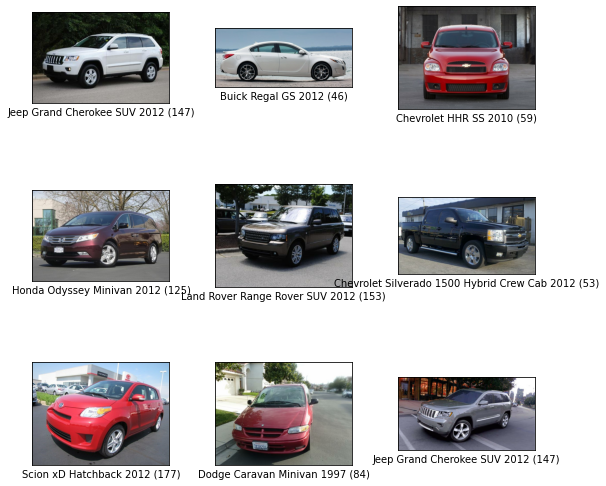

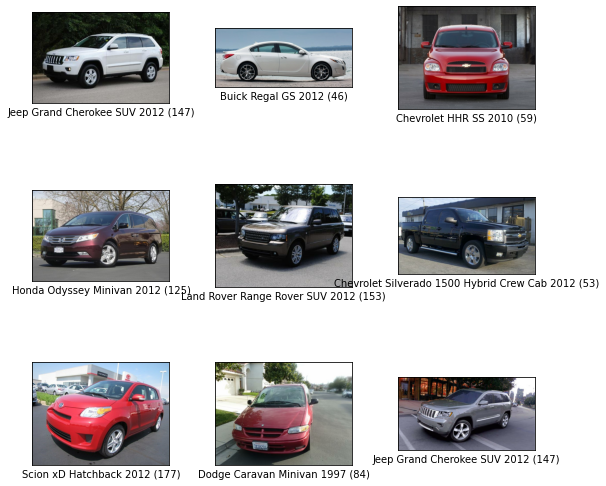

In [4]:
tfds.show_examples(ds_train, ds_info)

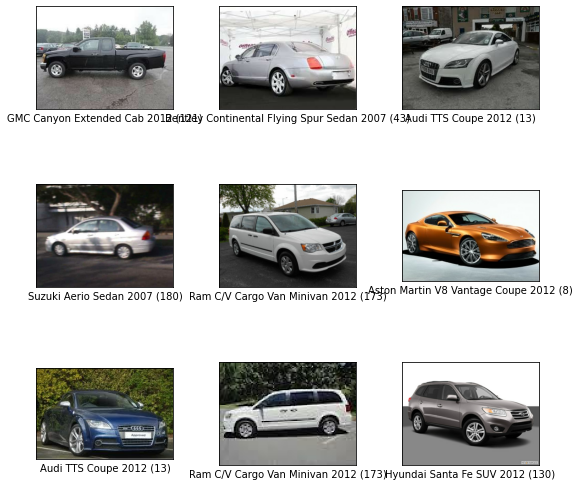

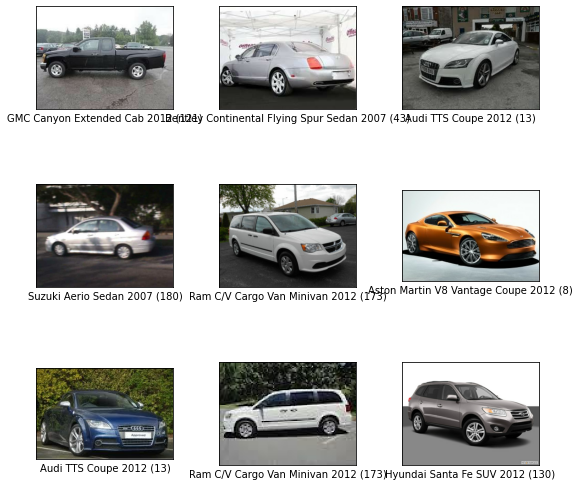

In [5]:
tfds.show_examples(ds_test, ds_info)

## (2) 물체의 위치정보
- bbox(바운딩 박스): BBoxFeature 타입으로 정의
- [y_min, x_min, y_max, x_max]를 나타냄

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

## (3) CAM을 위한 모델 만들기
- 이미지넷(imagenet) 데이터로 사전학습된 resnet50를 활용하고, pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델 구성
- 마지막 fully connected layer 대신 Global average pooling 사용
- conv5_block3_out의 output이 feature map이 된다. 이 feature map에 GAP을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행한다.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## (4) CAM 모델 학습하기
- CAM 모델의 학습에는 bbox 정보가 필요가 없으므로 제외
- CAM 모델은 bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식

In [9]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 112s 220ms/step - loss: 4.1459 - accuracy: 0.1625 - val_loss: 5.3925 - val_accuracy: 0.0121
Epoch 2/15
509/509 [==============================] - 81s 159ms/step - loss: 1.6117 - accuracy: 0.6431 - val_loss: 1.8088 - val_accuracy: 0.5340
Epoch 3/15
509/509 [==============================] - 81s 159ms/step - loss: 0.6049 - accuracy: 0.8897 - val_loss: 1.3322 - val_accuracy: 0.6545
Epoch 4/15
509/509 [==============================] - 88s 174ms/step - loss: 0.1808 - accuracy: 0.9824 - val_loss: 1.1286 - val_accuracy: 0.6998
Epoch 5/15
509/509 [==============================] - 82s 161ms/step - loss: 0.0762 - accuracy: 0.9958 - val_loss: 1.0184 - val_accuracy: 0.7260
Epoch 6/15
509/509 [==============================] - 82s 161ms/step - loss: 0.0332 - accuracy: 0.9989 - val_loss: 1.0022 - val_accuracy: 0.7317
Epoch 7/15
509/509 [==============================] - 90s 178ms/step - loss: 0.0266 - accuracy: 0.9986 - val_loss: 1.0206 - val_a

In [13]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


# Class Activation Map

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## (1) CAM
- CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 함
- CAM을 생성하기 위해서는 특성 맵, 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 원하는 클래스의 출력값이 필요
- 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 합니다. model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 `generate_cam()` 함수를 구현합니다.
- conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize 해주었습니다.

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

194


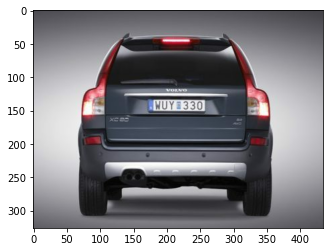

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [4]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

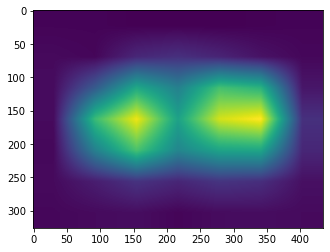

In [6]:
cam_image = generate_cam(cam_model, item)  # CAM 이미지 생성
plt.imshow(cam_image)

In [7]:
# CAM 이미지를 원본 이미지와 합치기
# 두 이미지의 투명도를 조정하고 하나의 이미지에서 원본과 CAM을 겹쳐 보여줌
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

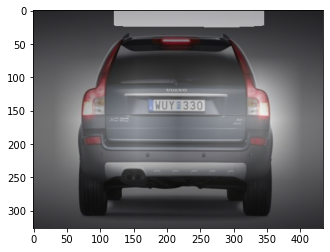

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## (2) Grad-CAM
- grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 됩니다.
- 위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다. 아래 `generate_grad_cam()`에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

64


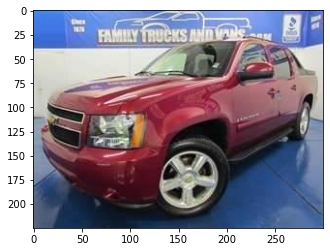

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [10]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

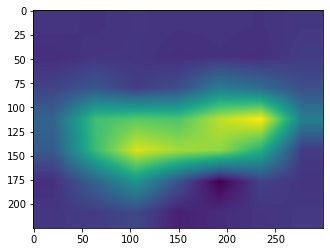

In [11]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

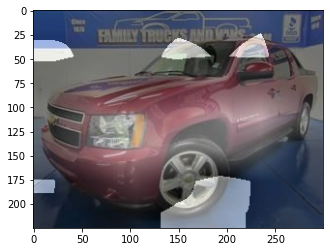

In [15]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

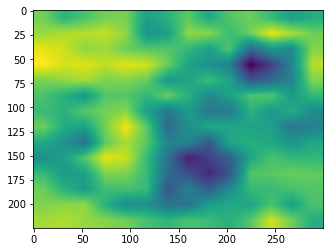

In [16]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

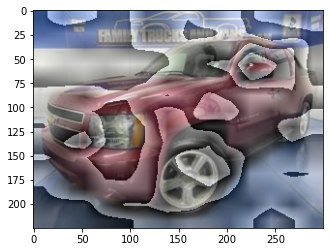

In [17]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

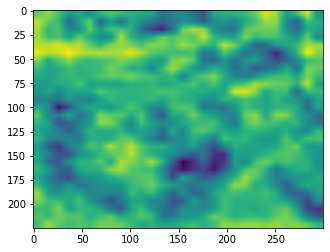

In [18]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

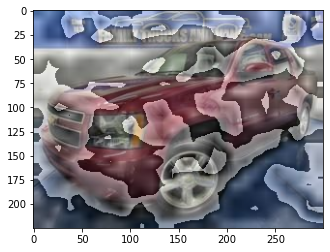

In [19]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

# Detection with CAM
## (1) 바운딩 박스
CAM에서 물체의 위치를 찾는 object detection을 위한 바운딩 박스 추출

### bbox from CAM

130


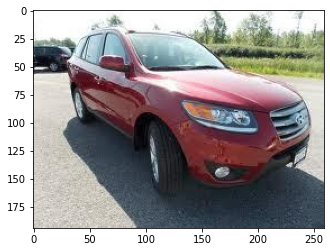

In [31]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

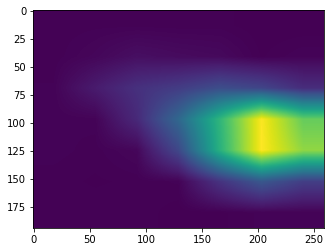

In [61]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [62]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh  # 역치값 이하의 바운딩 박스는 없앱니다.
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 사각형 찾기
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)  # 회전된 바운딩 박스 얻기
    rect = cv2.boxPoints(rotated_rect)  # 꼭지점으로 변환
    rect = np.int0(rect)  # int 자료형으로 변환
    return rect

In [63]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 45,  46],
       [258,  46],
       [258, 174],
       [ 45, 174]])

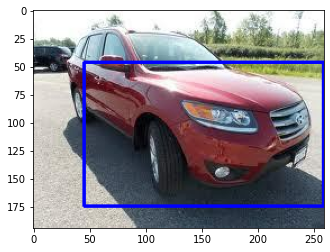

In [64]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

### bbox from Grad-CAM

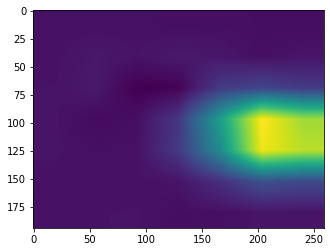

In [65]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [66]:
image = copy.deepcopy(item['image'])
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[107, 173],
       [107,  49],
       [257,  49],
       [257, 173]])

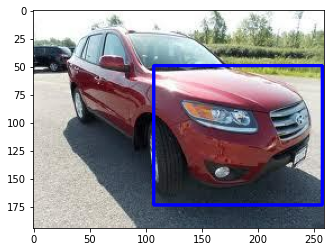

In [67]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)

## (2) Intersection Over Union
- IoU(Intersection over Union)는 두 개 영역의 합집합인 "union" 영역으로 교집합 영역인 "intersection" 영역의 넓이를 나누어준 값
- 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있으므로 모델이 영역을 잘 찾았는지 비교하는 좋은 지표임
- CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 얼마나 유사한지 IoU를 계산해서 확인

In [68]:
# 위에서 구한 rect를 minmax bbox 형태로 치환하는 함수
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1])   #bounding box의 x_max
    ]
    return bbox

In [69]:
# ground truth bbox
item['bbox']

array([0.08762886, 0.11969112, 0.8556701 , 0.98841697], dtype=float32)

In [70]:
# CAM의 bbox
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.23711340206185566,
 0.17374517374517376,
 0.8969072164948454,
 0.9961389961389961]

In [71]:
# Grad-CAM의 bbox
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
grad_pred_bbox

[0.25257731958762886,
 0.41312741312741313,
 0.8917525773195877,
 0.9922779922779923]

In [72]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [73]:
# CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
get_iou(pred_bbox, item['bbox'])

0.7138628014663486

In [74]:
# Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU
get_iou(grad_pred_bbox, item['bbox'])

0.5025077739516175

***
# 결과 비교
- CAM은 차량의 전면부와 측면의 일부에 이르는 넓은 범위에서 특징을 추출했다.
- Grad-CAM은 차종 분류 문제에서 가장 핵심이 되는 전면 헤드 부분에 집중하는 양상을 보였다.
- CAM의 바운딩 박스가 더 넓은 영역을 포함하여 정답과 겹치는 면적이 크기 때문에 IoU가 높게 나왔다.

| |CAM|Grad-CAM|
|:--:|:--:|:--:|
|image|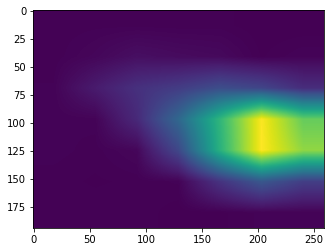|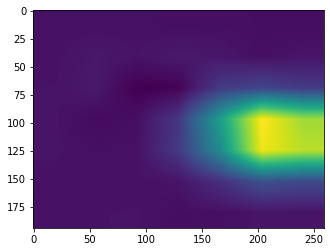|
|bbox|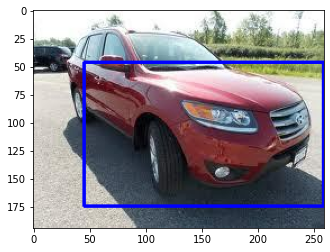|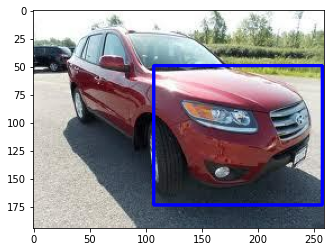|
|IoU|0.71|0.50|